# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [ ]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [ ]:
# Import essential libraries
import zipfile
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score


import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.applications import ResNet50 


import cv2

In [27]:
# Load and unzip the dataset
zip_datapath = "data.zip"

#extract from zip file
with zipfile.ZipFile(zip_datapath,'r') as zip_ref:
    zip_ref.extractall()
    
# Check the extracted folder
if os.path.exists("data"):
    print("Data extraction successful")
else:
    print("Data extraction failed")

Data extraction successful


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [ ]:
# Create a function to load the raw images

def load_imgaes_from_folder(data_path, target_size=(256, 256)):
    images = []
    labels = []
    class_names = sorted(os.listdir(data_path))

    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        if not os.path.isdir(class_path):
            continue
        for file in os.listdir(class_path):
            file_path = os.path.join(class_path, file)
            try:
                img = Image.open(file_path).convert('RGB')
                images.append(np.array(img))
                labels.append(idx)
            except:
                print(f"Could not load file {file_path}")

    return np.array(images), np.array(labels), class_names



#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [ ]:
# Get the images and their labels

# #load the data using custom function created above
dataset_dir = "data"
images, labels, class_names = load_imgaes_from_folder(dataset_dir)
print(f"Loaded {len(images)} images from {len(class_names)} classes.")


Loaded 7625 images from 7 classes.


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

In [4]:
# Create a DataFrame for class counts
def create_countdf(labels, class_names):
    label_series = pd.Series(labels)
    countdf = label_series.value_counts().sort_index().reset_index()
    countdf.columns = ['class_id', 'count']
    countdf['class_name'] = countdf['class_id'].apply(lambda x: class_names[x])
    return countdf

In [5]:
# Generate countdf
countdf = create_countdf(labels, class_names)

C:\Users\Ramadevi.Naredla\AppData\Local\Temp\ipykernel_13032\2211070586.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=countdf, x='class_name', y='count', palette='viridis')


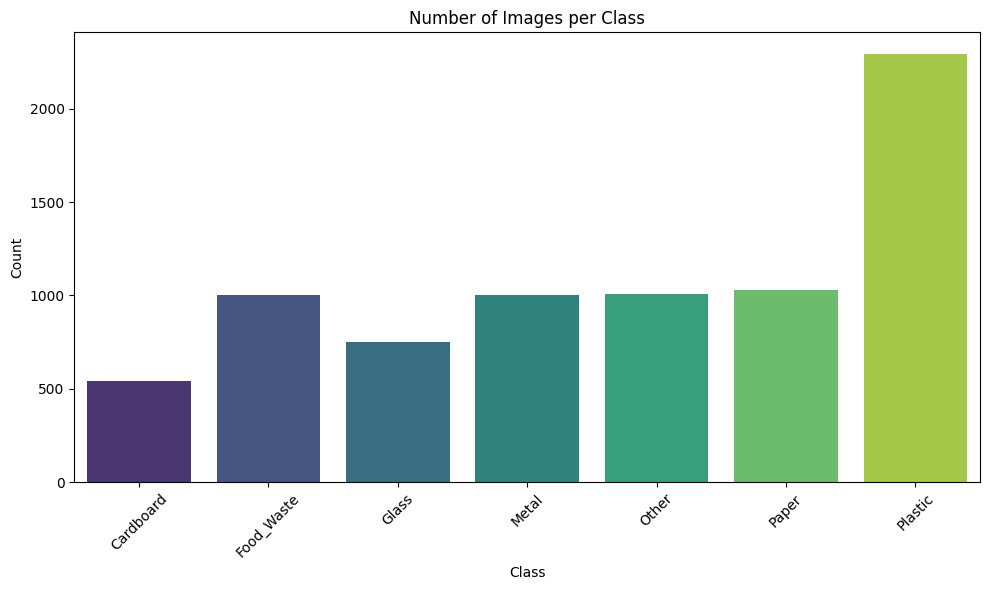

In [6]:
# Plotting the barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=countdf, x='class_name', y='count', palette='viridis')
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

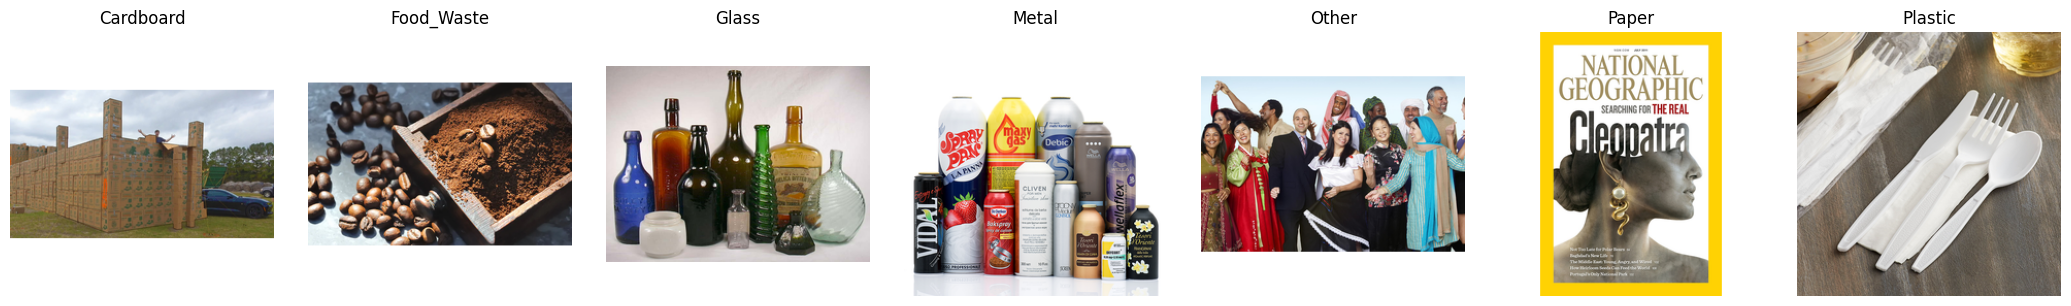

In [7]:
# Visualise Sample Images (across different labels)

shown_classes = set()
plt.figure(figsize=(len(class_names) * 3, 3))

for i, (img, lbl) in enumerate(zip(images, labels)):
    if lbl not in shown_classes:
        plt.subplot(1, len(class_names), len(shown_classes) + 1)
        plt.imshow(img)
        plt.title(class_names[lbl])
        plt.axis('off')
        shown_classes.add(lbl)

    if len(shown_classes) == len(class_names):
        break

plt.tight_layout()
plt.show()

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [8]:
# Find the smallest and largest image dimensions from the data set


def find_image_dimensions(images, labels):
    min_width, min_height = float('inf'),float('inf')
    max_width, max_height = 0,0

    for images, labels in zip(images, labels):
        for img in images:
            shape = img.shape #(height, width, channels)
            height,width = img.shape[:2]
           
            min_height = min(min_height,height)
            min_width = min(min_width,width)
            max_height = max(height,max_height)
            max_width = max(width,max_width)
    return (min_height,min_width),(max_height,max_width)

In [9]:
min_dim, max_dim = find_image_dimensions(images, labels)
print(f"Smallest image size (HxW): {min_dim}")
print(f"Largest image size (HxW): {max_dim}")

Smallest image size (HxW): (256, 3)
Largest image size (HxW): (256, 3)


In [10]:
# Resize the image dimensions
def resize_images(images, labels, target_size=(224, 224)):
    resized_images = []
    resized_labels = []

    for img, label in zip(images, labels):
        if img is None:
            continue
        resized_img = cv2.resize(img, target_size)
        resized_images.append(resized_img)
        resized_labels.append(label)  # Keep label aligned

    return np.array(resized_images), np.array(resized_labels)

In [11]:
# Resize the image dimensions
X, y = resize_images(images,labels, target_size=(128, 128))
print(X.shape)
print(labels.shape)


(7625, 128, 128, 3)
(7625,)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [12]:
# Encode the labels suitably


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)        # Convert to integers
y_one_hot = to_categorical(y_encoded)

print("Encoded y shape:", y_one_hot.shape)
#print("Sample labels:", labels.numpy())

Encoded y shape: (7625, 7)


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [13]:
# Assign specified parts of the dataset to train and validation sets

X_train, X_val, y_train, y_val = train_test_split(
    X, y_one_hot,
    test_size=0.2,
    random_state=42,
    stratify=labels
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_val.shape)
print("y_test shape:", y_val.shape)


X_train shape: (6100, 128, 128, 3)
y_train shape: (6100, 7)
X_test shape: (1525, 128, 128, 3)
y_test shape: (1525, 7)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [18]:
# Build and compile the model

input_shape = (128, 128, 3)
num_classes = 7
model = Sequential([
    #convolution layer 1
    layers.Conv2D(32,(3,3),activation='relu', input_shape=input_shape,padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.25),

    #convolution layer 2
    layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.25),

    # Convolutional Layer 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    #flatten layer
    layers.Flatten(),

    #fully connected layer 1 
    layers.Dense(512,activation = 'relu'),
    layers.Dropout(0.25),

    #output layer
    layers.Dense(num_classes,activation='softmax')                 
])


C:\Users\Ramadevi.Naredla\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
#compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'] )

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,875,463 (64.37 MB)

 Trainable params: 16,875,015 (64.37 MB)

 Non-trainable params: 448 (1.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [21]:
# Training

#Train mode, set parameters
epochs = 50
model_history =  model.fit(X_train,y_train,
                           batch_size=32,
                           epochs=epochs,
                           validation_data=(X_val,y_val))


Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 35s 179ms/step - accuracy: 0.2499 - loss: 8.9120 - val_accuracy: 0.2682 - val_loss: 2.1372
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 37s 192ms/step - accuracy: 0.3303 - loss: 1.7396 - val_accuracy: 0.1915 - val_loss: 3.0090
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 36s 188ms/step - accuracy: 0.3586 - loss: 1.6496 - val_accuracy: 0.3436 - val_loss: 2.1112
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 35s 185ms/step - accuracy: 0.3842 - loss: 1.5991 - val_accuracy: 0.3711 - val_loss: 2.0206
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 35s 184ms/step - accuracy: 0.4138 - loss: 1.5264 - val_accuracy: 0.4026 - val_loss: 1.7644
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 35s 184ms/step - accuracy: 0.4519 - loss: 1.4563 - val_accuracy: 0.4230 - val_loss: 1.5101
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 45s 236ms/step - accuracy: 0.4868 - loss: 1.3560 - val_accuracy: 0.4085 - val_loss: 5.8853
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 100s 331ms/step - accuracy: 0.5031 - loss: 

# train another model with differnt configuration

In [22]:
input_shape = (128, 128, 3)
num_classes = 7
model_2 = Sequential([
    #convolution layer 1
    layers.Conv2D(32,(3,3),activation='relu', input_shape=input_shape,padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.25),

    #convolution layer 2
    layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.25),

    # Convolutional Layer 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    #flatten layer
    layers.Flatten(),

    #fully connected layer 1 
    layers.Dense(128,activation = 'relu'),
    layers.Dropout(0.25),

    #output layer
    layers.Dense(num_classes,activation='softmax')                 
])


C:\Users\Ramadevi.Naredla\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
#compile model
model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'] )

model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289,479 (16.36 MB)

 Trainable params: 4,289,031 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [29]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy',patience=5,restore_best_weights=True)



In [ ]:
epochs = 30
model_2_history =  model_2.fit(X_train,y_train,
                           batch_size=32,
                           epochs=epochs,
                           call_backs = [early_stopping],
                           validation_data=(X_val,y_val))
# early_stopping is not giving out good results as the number of epoches is less, so removed it

In [32]:
epochs = 30
model_2_history =  model_2.fit(X_train,y_train,
                           batch_size=32,
                           epochs=epochs,
                           validation_data=(X_val,y_val))

Epoch 1/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 147ms/step - accuracy: 0.3095 - loss: 1.7911 - val_accuracy: 0.3003 - val_loss: 1.7469
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 29s 151ms/step - accuracy: 0.2953 - loss: 1.7732 - val_accuracy: 0.2944 - val_loss: 1.8246
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 29s 152ms/step - accuracy: 0.3087 - loss: 1.7480 - val_accuracy: 0.3003 - val_loss: 1.7889
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 29s 151ms/step - accuracy: 0.2972 - loss: 1.7410 - val_accuracy: 0.3003 - val_loss: 1.8642
Epoch 5/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.2963 - loss: 1.7237 - val_accuracy: 0.3010 - val_loss: 1.7136
Epoch 6/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 29s 151ms/step - accuracy: 0.3080 - loss: 1.7322 - val_accuracy: 0.2315 - val_loss: 3.8590
Epoch 7/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 146ms/step - accuracy: 0.3038 - loss: 1.7515 - val_accuracy: 0.3010 - val_loss: 1.7913
Epoch 8/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 145ms/step - accuracy: 0.2985 - loss: 1

# train using a pretrained model reset


In [ ]:
base_resnet_model = ResNet50(weights='imagenet', include_top=False,input_shape=input_shape)

#frees layers to not update weights
for layer in base_resnet_model.layers:
    layer.trainable = False

transfer_renet_model=Sequential([
    base_resnet_model,
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes,activation='softmax')
])


In [55]:
transfer_renet_model.compile(optimizer='adam',
                                       loss='categorical_crossentropy',
                                       metrics=['accuracy'])


In [56]:
transfer_renet_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,979,399 (121.99 MB)

 Trainable params: 8,391,175 (32.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

In [57]:
#train model
epochs = 20
reset_history=transfer_renet_model.fit(
    X_train,y_train,epochs=epochs,
    validation_data = (X_val,y_val)
)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 201ms/step - accuracy: 0.5614 - loss: 1.4714 - val_accuracy: 0.7574 - val_loss: 0.7166
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 213ms/step - accuracy: 0.8229 - loss: 0.5319 - val_accuracy: 0.7770 - val_loss: 0.6509
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 215ms/step - accuracy: 0.8995 - loss: 0.3030 - val_accuracy: 0.8052 - val_loss: 0.6664
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 212ms/step - accuracy: 0.9379 - loss: 0.2006 - val_accuracy: 0.8020 - val_loss: 0.6400
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 215ms/step - accuracy: 0.9478 - loss: 0.1647 - val_accuracy: 0.8131 - val_loss: 0.6581
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 40s 211ms/step - accuracy: 0.9679 - loss: 0.1235 - val_accuracy: 0.8295 - val_loss: 0.6300
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 40s 209ms/step - accuracy: 0.9745 - loss: 0.0926 - val_accuracy: 0.8151 - val_loss: 0.6744
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 40s 208ms/step - accuracy: 0.9806 - loss: 0

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [72]:
def plot_result_metrics(model_history,title):
    acc = model_history.history['accuracy']
    val_acc =  model_history.history['val_accuracy']
    loss =  model_history.history['loss']
    val_loss =  model_history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.suptitle(title, fontsize=20)  # <-- Add this line
    plt.tight_layout()
    plt.show()


### Results and metrics on model 1

In [74]:
# Evaluate on the test set; display suitable metrics
test_loss, test_acc = model.evaluate(X_val, y_val, verbose=2)
print("Accuracy scores on model 1")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

48/48 - 1s - 23ms/step - accuracy: 0.6203 - loss: 2.9343
Accuracy scores on model 1
Test Loss: 2.9343
Test Accuracy: 0.6203


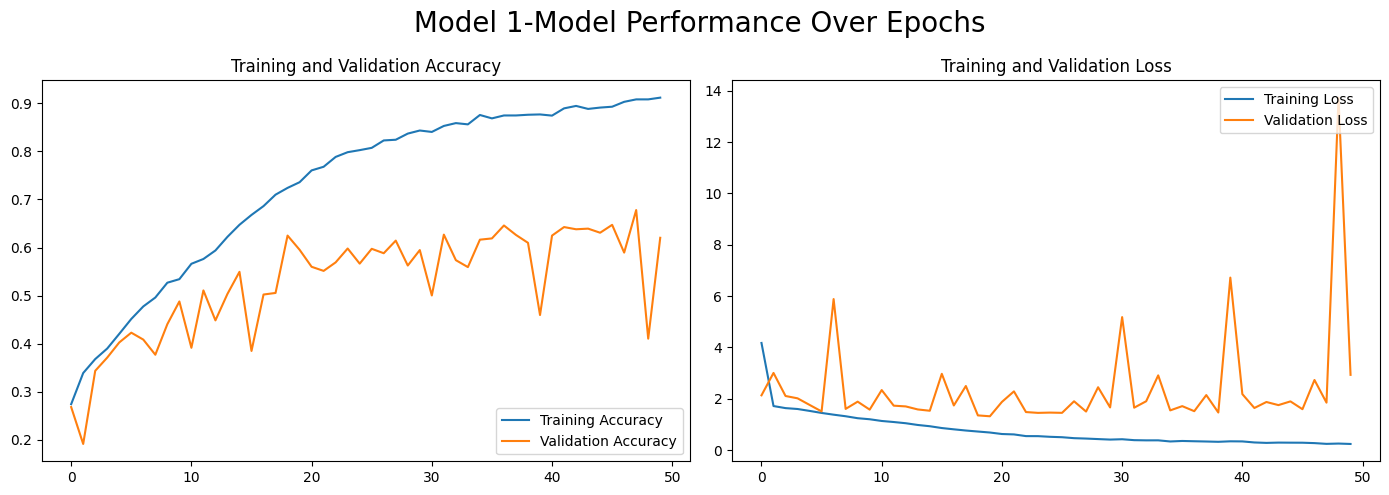

In [77]:
plot_result_metrics(model_history,' Model 1-Model Performance Over Epochs')

In [76]:
y_pred_probs = model.predict(X_val)
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_val.argmax(axis=1)

print("Model 1 - Classification report")
print(classification_report(y_true, y_pred))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Model 1 - Classification report
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       108
           1       0.69      0.68      0.68       200
           2       0.69      0.32      0.44       150
           3       0.75      0.55      0.64       200
           4       0.62      0.32      0.42       202
           5       0.68      0.52      0.59       206
           6       0.54      0.87      0.67       459

    accuracy                           0.62      1525
   macro avg       0.67      0.57      0.60      1525
weighted avg       0.65      0.62      0.60      1525



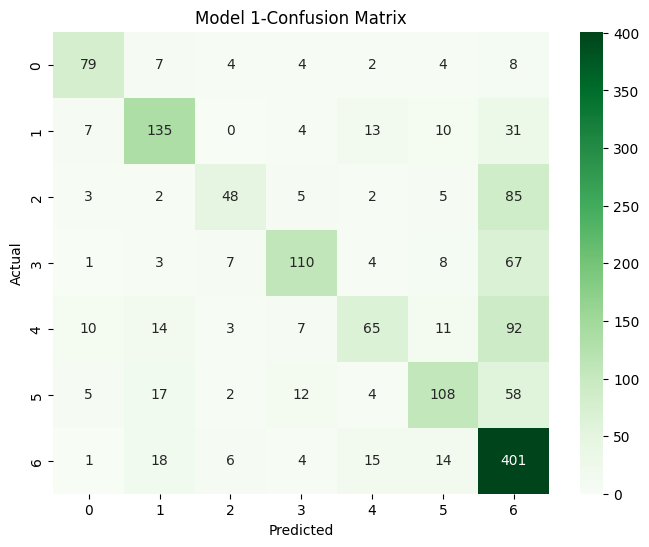

In [78]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Model 1-Confusion Matrix')
plt.show()

### Results and metrics on model 2

In [79]:
# Evaluate on the test set; display suitable metrics
test_loss, test_acc = model_2.evaluate(X_val, y_val, verbose=2)
print("Accuracy scores on model 2")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

48/48 - 1s - 22ms/step - accuracy: 0.4125 - loss: 1.5323
Accuracy scores on model 2
Test Loss: 1.5323
Test Accuracy: 0.4125


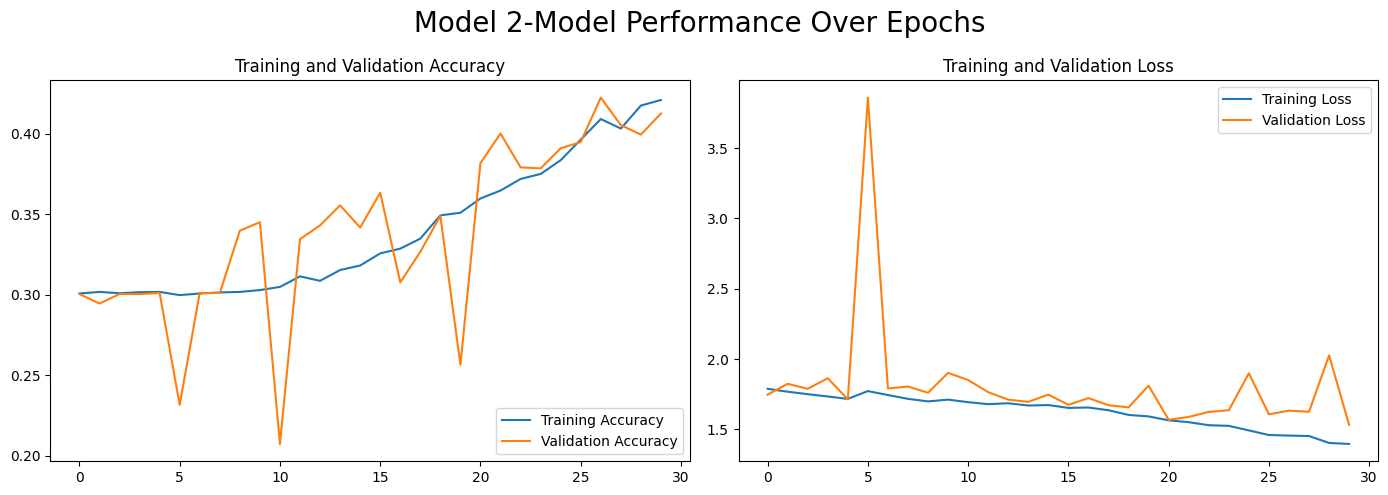

In [82]:
plot_result_metrics(model_2_history,' Model 2-Model Performance Over Epochs')

In [84]:
y_pred_probs = model_2.predict(X_val)
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_val.argmax(axis=1)

print("Model 2 - Classification report")
print(classification_report(y_true, y_pred))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Model 2 - Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       108
           1       0.28      0.84      0.42       200
           2       0.74      0.17      0.28       150
           3       0.35      0.23      0.28       200
           4       0.35      0.24      0.28       202
           5       1.00      0.00      0.01       206
           6       0.54      0.74      0.63       459

    accuracy                           0.41      1525
   macro avg       0.47      0.32      0.27      1525
weighted avg       0.50      0.41      0.35      1525



c:\Python\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


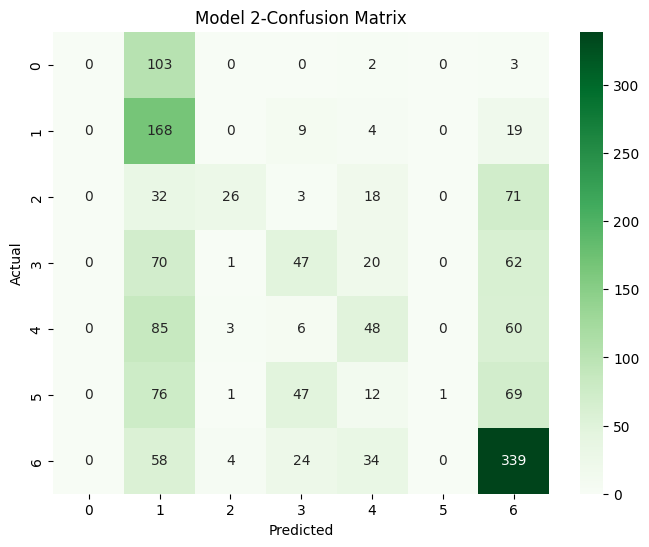

In [85]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Model 2-Confusion Matrix')
plt.show()

### Results and metrics on resnet transfer learning model

In [87]:
# Evaluate on the test set; display suitable metrics
test_loss, test_acc = transfer_renet_model.evaluate(X_val, y_val, verbose=2)
print("Accuracy scores on resnet transfer learning model")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

48/48 - 6s - 131ms/step - accuracy: 0.8046 - loss: 0.9412
Accuracy scores on resnet transfer learning model
Test Loss: 0.9412
Test Accuracy: 0.8046


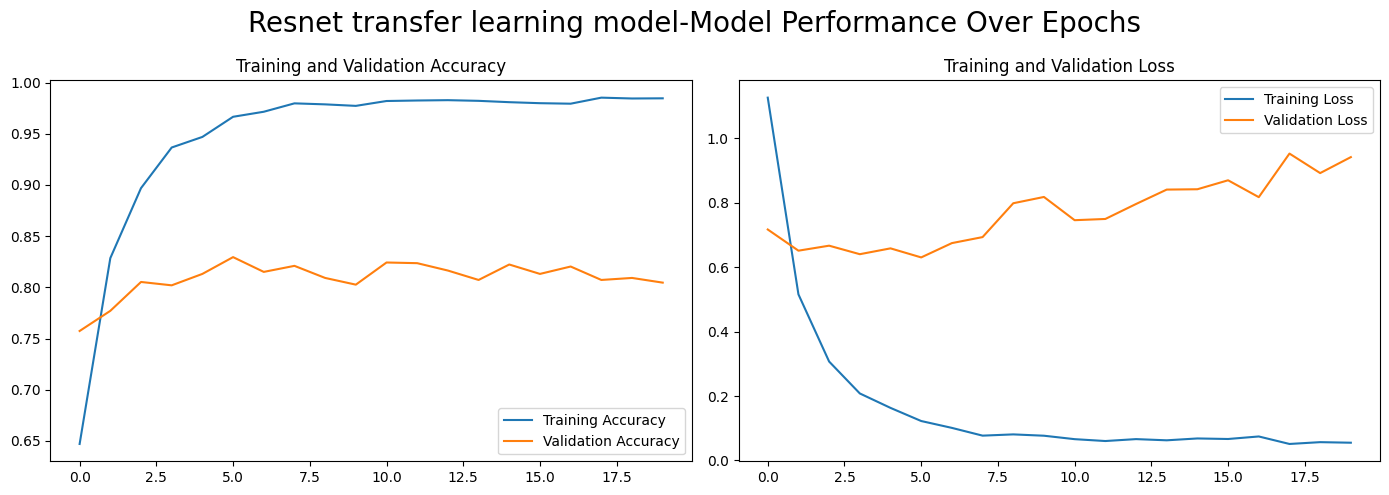

In [89]:
plot_result_metrics(reset_history,'Resnet transfer learning model-Model Performance Over Epochs')


In [90]:
y_pred_probs = transfer_renet_model.predict(X_val)
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_val.argmax(axis=1)

print("transfer_renet_model - Classification report")
print(classification_report(y_true, y_pred))

48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step
transfer_renet_model - Classification report
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       108
           1       0.79      0.82      0.80       200
           2       0.84      0.75      0.79       150
           3       0.93      0.83      0.88       200
           4       0.87      0.66      0.75       202
           5       0.77      0.66      0.71       206
           6       0.75      0.92      0.83       459

    accuracy                           0.80      1525
   macro avg       0.82      0.78      0.80      1525
weighted avg       0.81      0.80      0.80      1525



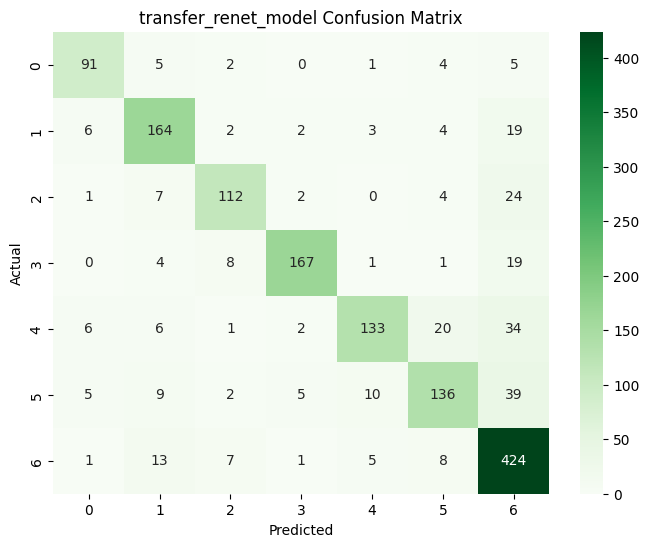

In [91]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('transfer_renet_model Confusion Matrix')
plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images




In [ ]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images



Purpose of Data Augmentation:

Improves model generalisation by artificially increasing the diversity of the training set.
Addresses class imbalance by augmenting underrepresented classes.
Common Augmentation Techniques:

Geometric Transformations: Rotation, scaling, translation, flipping.
Color Adjustments: Brightness, contrast, and saturation modifications.
Noise Injection: Adding slight noise to images.

Implementing in Practice:

Use libraries like Keras’ ImageDataGenerator or Albumentations to perform augmentation.

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

* **Report your findings about the data:**
##### 1.The dataset has seven differnt categories of images : 'Cardboard', 'Food Waste', 'Glass', 'Metal', 'Other', 'Paper', and 'Plastic'.
##### 2.The count distribution of images across the classes is as below:

      Plastic: 2,295 
      Food Waste: 1,000 
      Cardboard: 540 
      Metal: 1,000      
      Glass: 750 
      Paper: 1,030     
      Other: 1,010 
      
##### 3.Total images in the dataset: 7,625 images.
##### 4.All images in dataset are of size are 256x256 pixels and RGB type.
##### 5. During modeling, divided dataset into 80% for training and 20% for testing

* **Report model training results:**
##### 1.Built total 3 model, 2 models from scratch using convolution and fully connected layers and 1 model using transfer learning 
##### 2.The newly built convolutional neural network (CNN) model has got the test accuracy of 62% and model f1 score is 0.6
##### 2.ResNet50 base mode with transfer learning applied with given dataset has got test accuracy of 80% and f1 score is 0.8
##### 4.The loss on the test data also decreases in ResNet50 compared with regular CNN model
##### 6.Conclusion, the ResNet50 base model with transfer learning on the give dataset gives the best results for image classification compare with regular newly built CNN models